#### <center>Predicting Seoul Bike Rental Demand Based on Weather and Temporal Factors</center>
#### <center>Miles A. Peña</center>
#### <center>June 1, 2025</center>

#### Data Sources and Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# load data
data = pd.read_csv('SeoulBikeData.csv', encoding='latin1')

In [4]:
# preview and preprocess
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data['Hour'] = pd.to_datetime(data['Hour'], format='%H').dt.hour
data.fillna(data.mean(numeric_only=True), inplace=True)

In [23]:
# feature engineering
data['AvgHourlyRental'] = data.groupby('Hour')['Rented Bike Count'].transform('mean')
data['TempBand'] = pd.cut(data['Temperature(°C)'], bins=[-10, 0, 10, 20, 30, 40], labels=['Very Cold', 'Cold', 'Mild', 'Warm', 'Hot'])
data.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,AvgHourlyRental,TempBand,Weekday
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,541.460274,Very Cold,Friday
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,426.183562,Very Cold,Friday
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,301.630137,Very Cold,Friday
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,203.331507,Very Cold,Friday
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,132.591781,Very Cold,Friday


In [6]:
# select and normalize features
features = ['Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)',
            'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Hour']
X = data[features]
y = data['Rented Bike Count']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#### Exploratory Data Analysis (EDA)

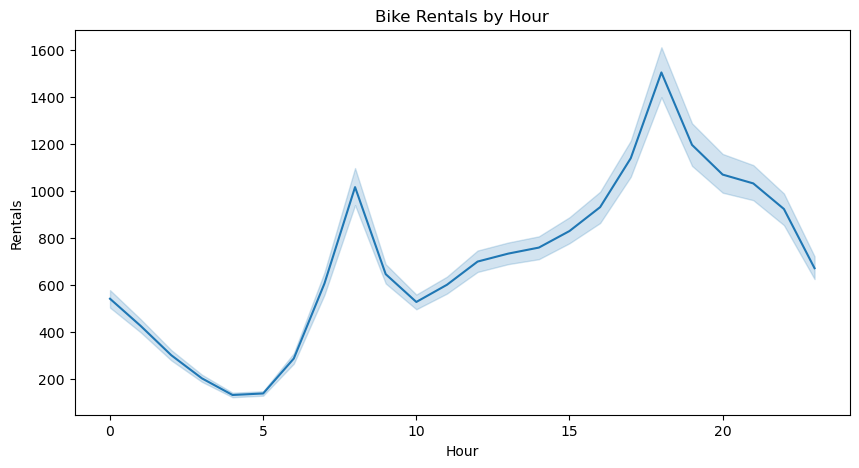

In [7]:
# rentals by Hour
plt.figure(figsize=(10, 5))
sns.lineplot(x='Hour', y='Rented Bike Count', data=data)
plt.title('Bike Rentals by Hour')
plt.xlabel('Hour')
plt.ylabel('Rentals')
plt.show()

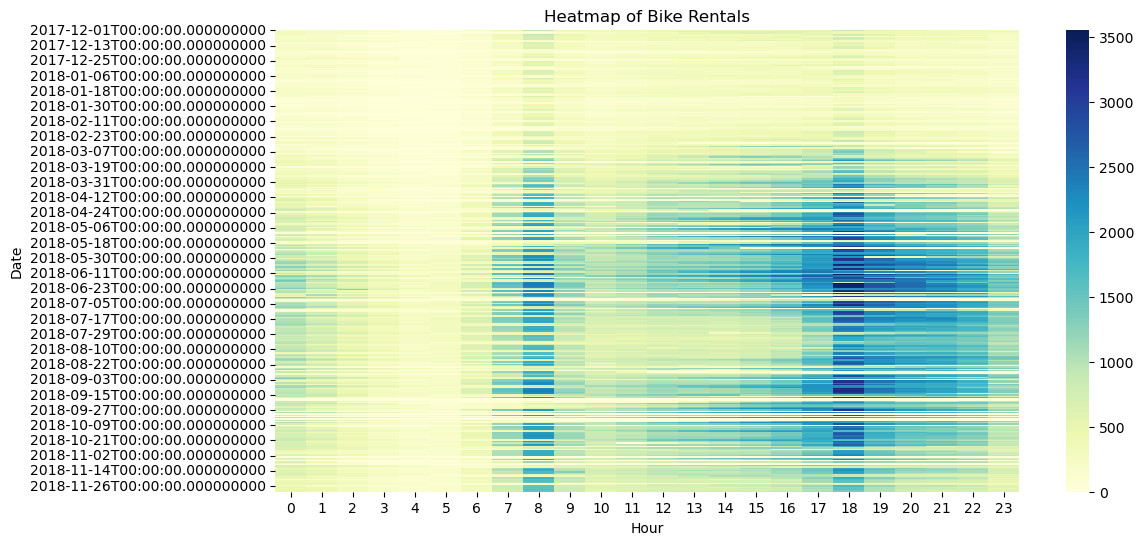

In [8]:
# heatmap by Date and Hour
pivot_table = data.pivot_table(index='Date', columns='Hour', values='Rented Bike Count')
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='YlGnBu')
plt.title('Heatmap of Bike Rentals')
plt.show()

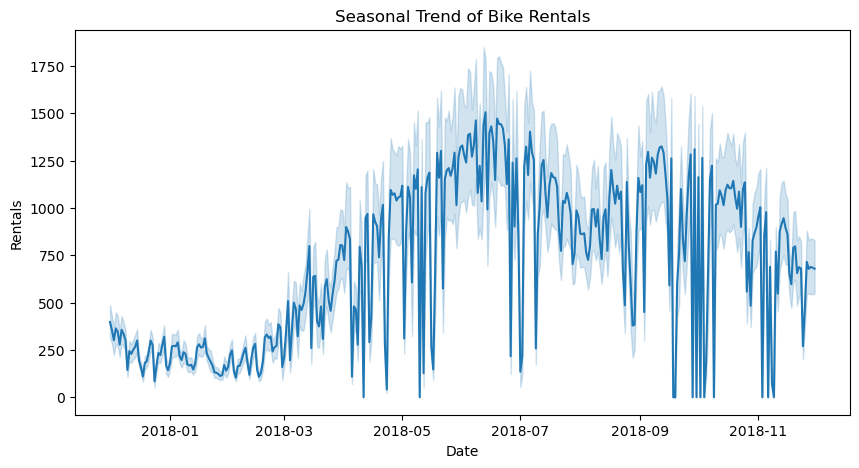

In [9]:
# seasonal Trend
plt.figure(figsize=(10, 5))
sns.lineplot(x='Date', y='Rented Bike Count', data=data)
plt.title('Seasonal Trend of Bike Rentals')
plt.xlabel('Date')
plt.ylabel('Rentals')
plt.show()

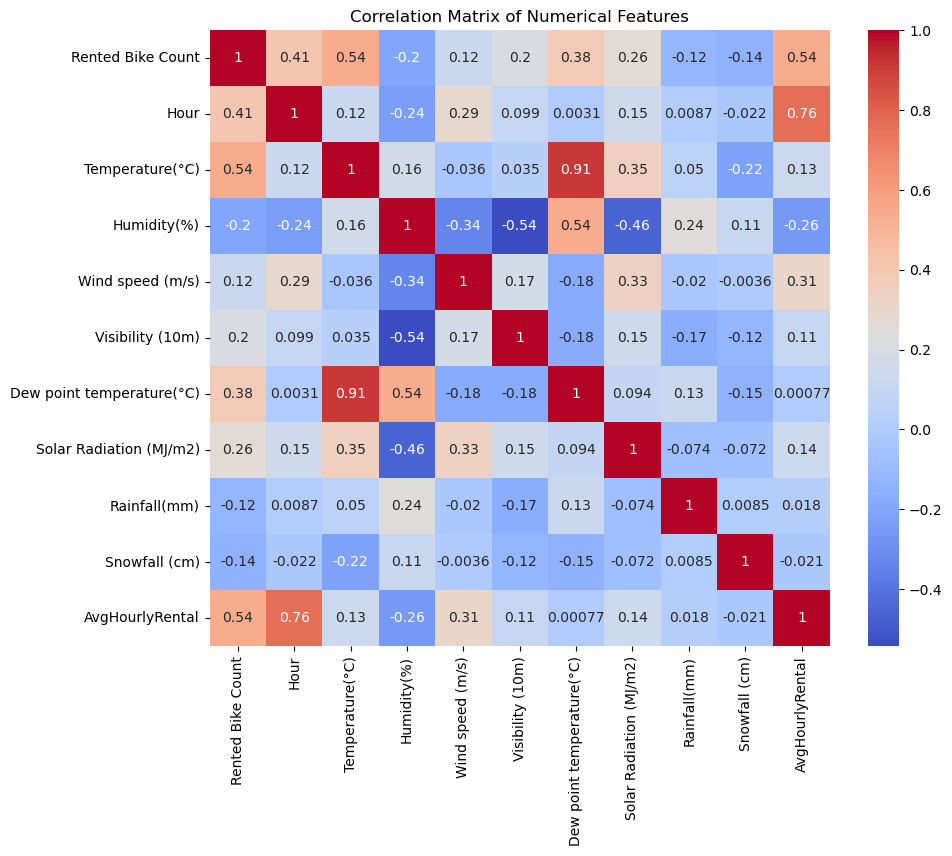

In [11]:
# correlation heatmap
plt.figure(figsize=(10, 8))
corr = data.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

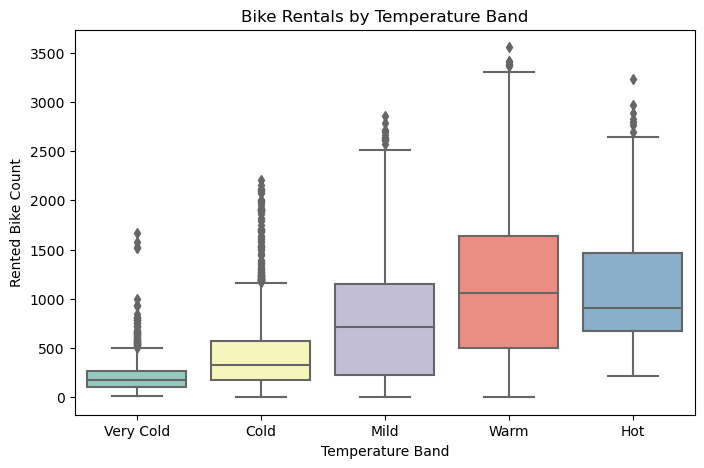

In [12]:
# boxplot of rentals by temperature band
plt.figure(figsize=(8, 5))
sns.boxplot(x='TempBand', y='Rented Bike Count', data=data, palette='Set3')
plt.title('Bike Rentals by Temperature Band')
plt.xlabel('Temperature Band')
plt.ylabel('Rented Bike Count')
plt.show()

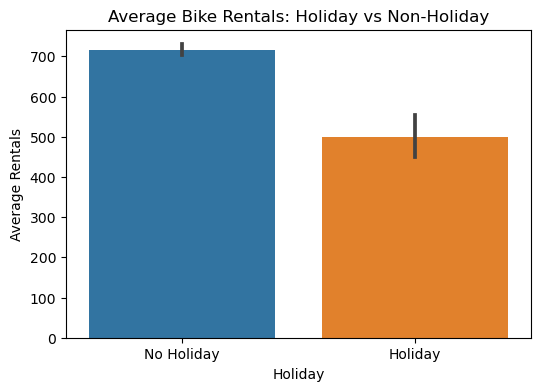

In [14]:
# average rentals on holidays vs non-holidays
plt.figure(figsize=(6, 4))
sns.barplot(x='Holiday', y='Rented Bike Count', data=data, estimator=np.mean)
plt.title('Average Bike Rentals: Holiday vs Non-Holiday')
plt.ylabel('Average Rentals')
plt.show()

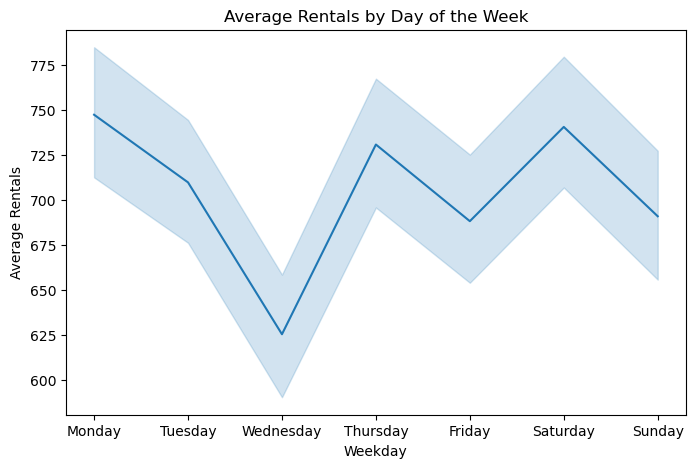

In [15]:
# weekly rental patterns
data['Weekday'] = data['Date'].dt.day_name()
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(8, 5))
sns.lineplot(x='Weekday', y='Rented Bike Count', data=data, estimator=np.mean, sort=False)
plt.xticks(ticks=range(7), labels=order)
plt.title('Average Rentals by Day of the Week')
plt.ylabel('Average Rentals')
plt.show()

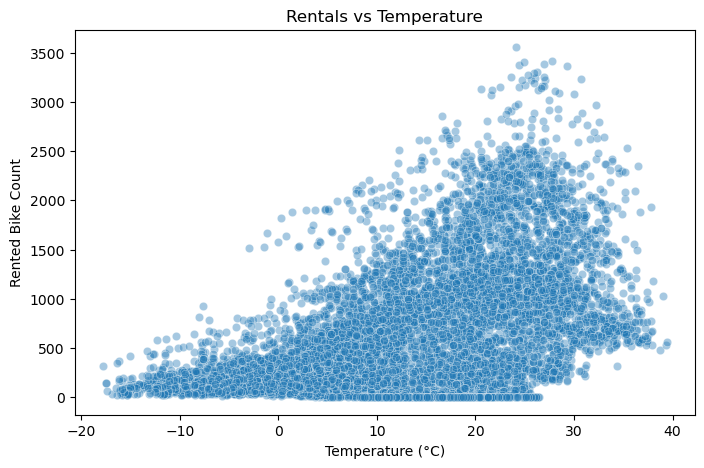

In [16]:
# rentals vs temperature
plt.figure(figsize=(8, 5))
sns.scatterplot(x='Temperature(°C)', y='Rented Bike Count', data=data, alpha=0.4)
plt.title('Rentals vs Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Rented Bike Count')
plt.show()

#### Predictive Modeling

In [17]:
# regression models
models = {
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Linear Regression': LinearRegression()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    print(f'{name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}')

Random Forest - RMSE: 310.26, MAE: 185.07
Gradient Boosting - RMSE: 326.41, MAE: 206.19
Linear Regression - RMSE: 472.17, MAE: 349.49


In [18]:
# ARIMA time-series model
arima = ARIMA(y, order=(5,1,0))
arima_fit = arima.fit()
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:      Rented Bike Count   No. Observations:                 8760
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -61527.800
Date:                Tue, 20 May 2025   AIC                         123067.601
Time:                        19:00:04   BIC                         123110.068
Sample:                             0   HQIC                        123082.071
                               - 8760                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2568      0.009     29.077      0.000       0.239       0.274
ar.L2         -0.1553      0.015    -10.283      0.000      -0.185      -0.126
ar.L3         -0.0020      0.017     -0.119      0.9

#### Predicted vs Actual

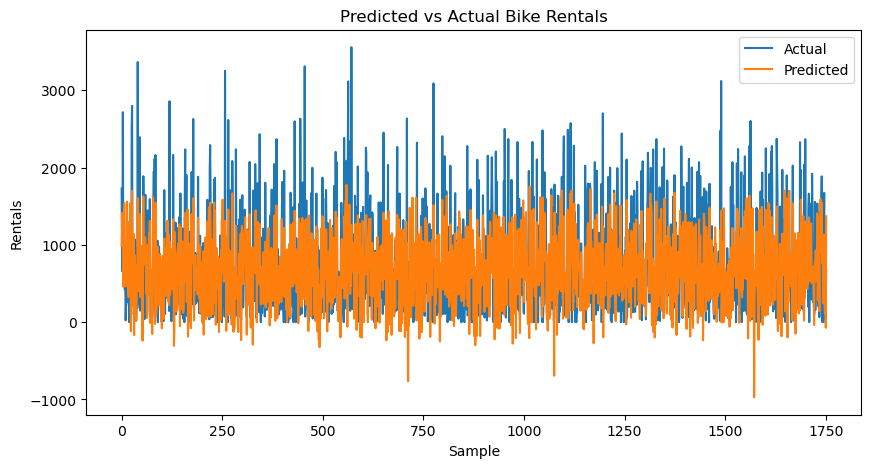

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Predicted vs Actual Bike Rentals')
plt.xlabel('Sample')
plt.ylabel('Rentals')
plt.legend()
plt.show()

#### Conclusion

This project successfully demonstrated the use of machine learning to predict hourly bike rental demand in Seoul based on weather and temporal variables. Through data cleaning, feature engineering, and the application of multiple regression and time-series models, I found that environmental conditions such as temperature, humidity, and solar radiation significantly influence rental patterns, alongside factors like hour of day and holidays.

The Random Forest and Gradient Boosting models outperformed simpler models in terms of accuracy, as measured by RMSE and MAE, suggesting they are well-suited for operational forecasting. These models can support real-world decision-making by helping bike-sharing operators better anticipate demand and allocate bikes more efficiently. Future enhancements could include the integration of geospatial data and real-time weather feeds to further refine predictions.

Overall, this analysis provides a practical foundation for data-driven transportation planning in urban environments.